# K-means Baseline (on Unclean Data) 


**Goal:** 
Use simple spectral features (delta, theta, gamma, HF power) from rodent HPC & PFC signals  
to see if **unsupervised clustering (K-means)** can separate known sleep states  
and **validate whether our preprocessing helps reveal meaningful structure**.

If clustering improves after basic downsampling or filtering,  
that suggests our preprocessing enhances biological signal quality.

so we need to : 
- Validate that the signals to see if it contain enough structure to separate sleep states.
- Use K-means as a **validation tool** for preprocessing quality:
   if clustering improves when data is cleaned,
   it means preprocessing is helping us.

## 1) Parameters

In [114]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, scipy.io as sio
from scipy.signal import spectrogram
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8-whitegrid")

# --- Paths (edit these) ---
HPC_PATH        = r"../../data/prerprocessed/rat_exp1_jour1/EMG1.csv"
PFC_PATH        = r"../../data/prerprocessed/rat_exp1_jour1/PFC1.csv"
STATES_MAT_PATH = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/post_trial1_2017-09-28_11-30-59-states.mat"
EMG_PATH      = r"../../data/prerprocessed/rat_exp1_jour1/EMG1.csv"
# --- Signal & windowing ---
FS = 500         # Hz
EPOCH_S = 2      # 2-s “analysis bin”
RNG = 42

# --- Frequency bands (richer set) ---
BANDS = {
    "delta": (0.5, 4),
    "theta": (6, 9),
    "sigma": (12, 16),   # spindles
    "beta":  (15, 30),
    "gamma": (30, 80),
}
ORDER = ["delta","theta","sigma","beta","gamma"]  # desired column order

In [115]:
def load_csv_1d(path):
    df = pd.read_csv(path)
    num = df.select_dtypes(include=[np.number]).columns
    if len(num)==0:
        raise ValueError(f"No numeric column in {path}")
    return df[num[0]].to_numpy(float)

def load_states_1hz_mat(path):
    try:
        m = sio.loadmat(path)
        for k,v in m.items():
            if isinstance(v, np.ndarray) and v.ndim==1 and v.size>10:
                return v.squeeze().astype(int)
    except Exception:
        pass
    return None

hpc = load_csv_1d(HPC_PATH)
pfc = load_csv_1d(PFC_PATH)
states_1hz = load_states_1hz_mat(STATES_PATH)

print("Loaded:", hpc.shape, pfc.shape, None if states_1hz is None else states_1hz.shape)


Loaded: (1342538,) (1342538,) None


In [116]:
def bandpowers(sig, fs, bands, nperseg):
    f,t,Sxx = spectrogram(sig, fs=fs, nperseg=nperseg, noverlap=0,
                          detrend=False, scaling="density", mode="psd")
    out = {}
    for name,(lo,hi) in bands.items():
        mask = (f>=lo)&(f<=hi)
        out[name] = np.trapz(Sxx[mask,:], f[mask], axis=0)
    return f,t,out

def bp_to_matrix(bp_dict, order=ORDER):
    cols, names = [], []
    for b in order:
        if b in bp_dict:
            cols.append(bp_dict[b])
            names.append(b)
    if not cols:
        raise ValueError("No matching bands in dict.")
    return np.column_stack(cols), names

def norm_block(mat):
    # log1p then column-wise mean-normalize (keeps within-modality balance)
    m = np.log1p(np.clip(mat,0,None))
    m = m / (m.mean(axis=0) + 1e-12)
    return m

def make_ratios(mat, names):
    ix = {n:i for i,n in enumerate(names)}
    feats, fnames = [], []
    if "theta" in ix and "delta" in ix:
        feats.append( mat[:,ix["theta"]] / (mat[:,ix["delta"]]+1e-12) ); fnames.append("θ/δ")
    if "gamma" in ix and "theta" in ix:
        feats.append( mat[:,ix["gamma"]] / (mat[:,ix["theta"]]+1e-12) ); fnames.append("γ/θ")
    return (np.column_stack(feats), fnames) if feats else (None, [])

nperseg = int(FS*EPOCH_S)

# HPC
_, t_hpc, bp_hpc = bandpowers(hpc, FS, BANDS, nperseg)
hpc_mat, hpc_bnames = bp_to_matrix(bp_hpc)
hpc_norm = norm_block(hpc_mat)
hpc_rat, hpc_rnames = make_ratios(hpc_norm, hpc_bnames)

# PFC
_, t_pfc, bp_pfc = bandpowers(pfc, FS, BANDS, nperseg)
pfc_mat, pfc_bnames = bp_to_matrix(bp_pfc)
pfc_norm = norm_block(pfc_mat)
pfc_rat, pfc_rnames = make_ratios(pfc_norm, pfc_bnames)

# Align time bins
T = min(hpc_norm.shape[0], pfc_norm.shape[0])
hpc_norm, pfc_norm = hpc_norm[:T], pfc_norm[:T]
if hpc_rat is not None: hpc_rat = hpc_rat[:T]
if pfc_rat is not None: pfc_rat = pfc_rat[:T]
t_bins = np.arange(T) * EPOCH_S

# Assemble final features (HPC | PFC | ratios)
blocks, names = [hpc_norm, pfc_norm], [f"HPC_{b}" for b in hpc_bnames] + [f"PFC_{b}" for b in pfc_bnames]
if hpc_rat is not None:
    blocks.append(hpc_rat); names += [f"HPC_{x}" for x in hpc_rnames]
if pfc_rat is not None:
    blocks.append(pfc_rat); names += [f"PFC_{x}" for x in pfc_rnames]

X = np.hstack(blocks)
feat_names = names
print("Feature matrix:", X.shape)


Feature matrix: (1342, 14)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_19856\2084449057.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out[name] = np.trapz(Sxx[mask,:], f[mask], axis=0)


In [117]:
from sklearn.preprocessing import RobustScaler

# block indices
n_hpc = len(hpc_bnames)
n_pfc = len(pfc_bnames)
n_rat_hpc = 0 if hpc_rat is None else hpc_rat.shape[1]
n_rat_pfc = 0 if pfc_rat is None else pfc_rat.shape[1]

i0 = 0
blk_hpc = slice(i0, i0+n_hpc); i0 += n_hpc
blk_pfc = slice(i0, i0+n_pfc); i0 += n_pfc
blk_rh = slice(i0, i0+n_rat_hpc); i0 += n_rat_hpc
blk_rp = slice(i0, i0+n_rat_pfc); i0 += n_rat_pfc

def block_scale(X, blocks):
    outs = []
    for s in blocks:
        if s.start == s.stop: continue
        outs.append(RobustScaler().fit_transform(X[:, s]))
    return np.hstack(outs)

X_scaled = block_scale(X, [blk_hpc, blk_pfc, blk_rh, blk_rp])

# (optional) quick variance & correlation view
print(pd.Series(X.var(axis=0), index=feat_names).sort_values(ascending=False).head(10))
pd.DataFrame(X_scaled, columns=feat_names).corr().style.background_gradient(cmap='coolwarm')


HPC_γ/θ      2340.668390
HPC_theta       0.739405
HPC_sigma       0.717146
HPC_delta       0.717142
HPC_beta        0.672216
HPC_gamma       0.202180
HPC_θ/δ         0.070219
PFC_γ/θ         0.025811
PFC_delta       0.023260
PFC_theta       0.015196
dtype: float64


,HPC_delta,HPC_theta,HPC_sigma,HPC_beta,HPC_gamma,PFC_delta,PFC_theta,PFC_sigma,PFC_beta,PFC_gamma,HPC_θ/δ,HPC_γ/θ,PFC_θ/δ,PFC_γ/θ
HPC_delta,1.000000,0.993934,0.994812,0.993859,0.975025,-0.423857,-0.482465,-0.418763,-0.100348,0.682289,0.361590,-0.436061,0.001384,0.612599
HPC_theta,0.993934,1.000000,0.998264,0.997926,0.978514,-0.425811,-0.482003,-0.425257,-0.107440,0.677208,0.394152,-0.433042,0.004041,0.610332
HPC_sigma,0.994812,0.998264,1.000000,0.998664,0.978801,-0.423871,-0.479508,-0.423108,-0.106478,0.678508,0.388124,-0.433938,0.004125,0.608755
HPC_beta,0.993859,0.997926,0.998664,1.000000,0.977725,-0.423284,-0.480574,-0.422429,-0.106511,0.678272,0.389425,-0.434265,0.002114,0.609531
HPC_gamma,0.975025,0.978514,0.978801,0.977725,1.000000,-0.405220,-0.457596,-0.409070,-0.112960,0.656401,0.369796,-0.414169,0.004662,0.584256
PFC_delta,-0.423857,-0.425811,-0.423871,-0.423284,-0.405220,1.000000,0.651547,0.465914,0.113345,-0.454162,-0.260566,0.275759,-0.575882,-0.641020
PFC_theta,-0.482465,-0.482003,-0.479508,-0.480574,-0.457596,0.651547,1.000000,0.447438,0.158644,-0.447021,-0.278343,0.322912,0.232725,-0.935762
PFC_sigma,-0.418763,-0.425257,-0.423108,-0.422429,-0.409070,0.465914,0.447438,1.000000,0.405848,-0.372900,-0.182492,0.215332,-0.116935,-0.467909
PFC_beta,-0.100348,-0.107440,-0.106478,-0.106511,-0.112960,0.113345,0.158644,0.405848,1.000000,0.107163,-0.062850,0.107472,0.040097,-0.078402
PFC_gamma,0.682289,0.677208,0.678508,0.678272,0.656401,-0.454162,-0.447021,-0.372900,0.107163,1.000000,0.254530,-0.290369,0.111438,0.708777


In [118]:
labels_bins = None
if states_1hz is not None and len(states_1hz) >= T*EPOCH_S:
    y = states_1hz[:T*EPOCH_S].reshape(T, EPOCH_S)
    labels_bins = np.array([np.bincount(row).argmax() for row in y])
    print("Mapped manual labels:", labels_bins.shape, np.unique(labels_bins))
else:
    print("No/short manual labels → skipping mapping.")


No/short manual labels → skipping mapping.


Silhouette per k: {2: 0.734, 3: 0.465, 4: 0.379, 5: 0.345, 6: 0.285, 7: 0.209, 8: 0.159, 9: 0.166, 10: 0.172}
Chosen k = 2  (silhouette = 0.734)


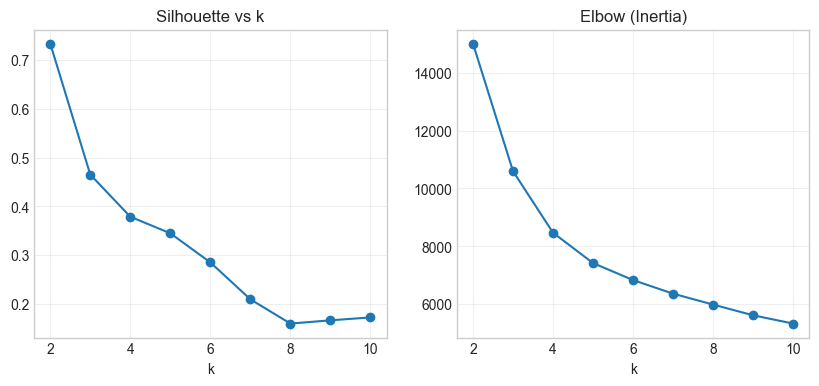

In [119]:
K_RANGE = range(2, 11)
sils, inertias = [], []

for k in K_RANGE:
    km_tmp = KMeans(n_clusters=k, n_init=25, random_state=RNG).fit(X_scaled)
    sils.append(silhouette_score(X_scaled, km_tmp.labels_))
    inertias.append(km_tmp.inertia_)

best_k = K_RANGE[int(np.argmax(sils))]
print("Silhouette per k:", dict(zip(K_RANGE, [round(s,3) for s in sils])))
print(f"Chosen k = {best_k}  (silhouette = {sils[K_RANGE.index(best_k)]:.3f})")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(K_RANGE, sils, marker='o'); ax[0].set_title("Silhouette vs k"); ax[0].set_xlabel("k"); ax[0].grid(alpha=.3)
ax[1].plot(K_RANGE, inertias, marker='o'); ax[1].set_title("Elbow (Inertia)"); ax[1].set_xlabel("k"); ax[1].grid(alpha=.3)
plt.show()


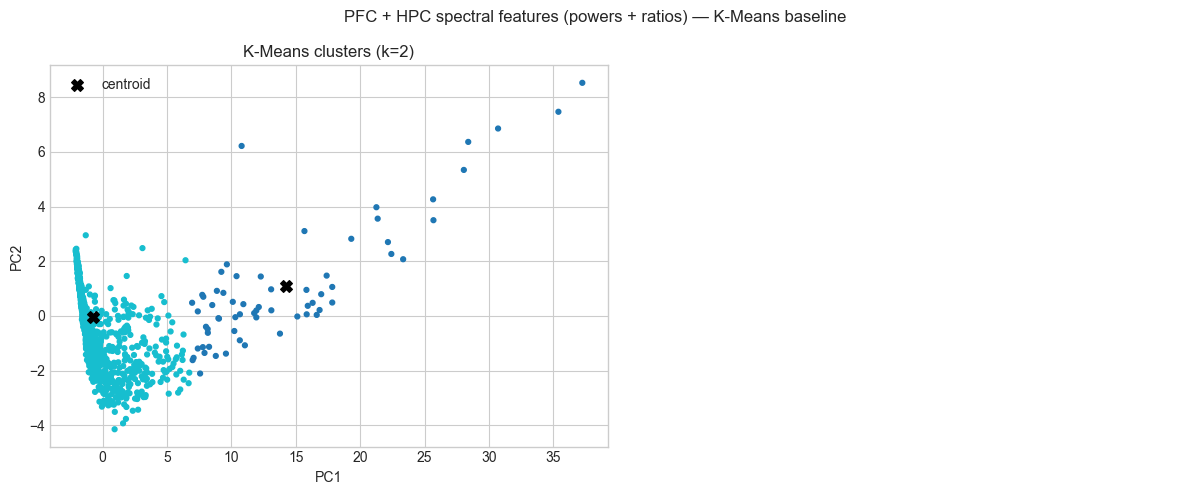

In [120]:
km = KMeans(n_clusters=best_k, n_init=50, random_state=RNG).fit(X_scaled)
clusters = km.labels_

pca = PCA(2, random_state=RNG).fit(X_scaled)
X_pca = pca.transform(X_scaled)
centers_2d = pca.transform(km.cluster_centers_)

fig, axs = plt.subplots(1,2, figsize=(12,5))

# left: clusters
axs[0].scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=12)
axs[0].scatter(centers_2d[:,0], centers_2d[:,1], c='k', s=70, marker='X', label='centroid')
axs[0].set_title(f"K-Means clusters (k={best_k})"); axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")
axs[0].legend(loc="best")

# right: manual states if available
if labels_bins is not None:
    state_names  = {1:"Wake", 3:"NREM", 4:"Intermediate", 5:"REM"}
    state_colors = {1:"#E64B35", 3:"#4DBBD5", 4:"#B39DDB", 5:"#00A087"}
    for s in sorted(np.unique(labels_bins)):
        m = labels_bins == s
        axs[1].scatter(X_pca[m,0], X_pca[m,1], c=state_colors.get(s,"#888888"), s=12, label=f"{s}={state_names.get(s,'?')}")
    axs[1].legend(title="Manual states", loc="best")
    axs[1].set_title("Manual labels (PCA view)")
    axs[1].set_xlabel("PC1"); axs[1].set_ylabel("PC2")
else:
    axs[1].axis("off")

plt.suptitle("PFC + HPC spectral features (powers + ratios) — K-Means baseline")
plt.tight_layout(); plt.show()


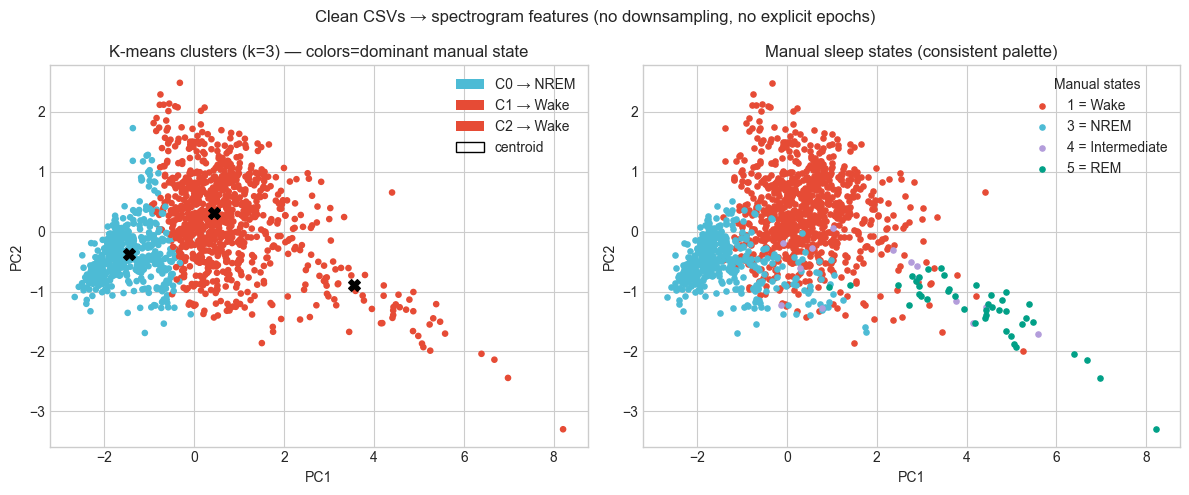

In [ ]:
if labels_bins is not None:
    ari = adjusted_rand_score(labels_bins, clusters)
    print(f"Adjusted Rand Index (manual vs clusters) = {ari:.3f}")
    print("\nContingency table:")
    print(pd.crosstab(labels_bins, clusters, rownames=["Manual"], colnames=["Cluster"]))


In [102]:
pd.DataFrame(X, columns=feat_names).var().sort_values(ascending=False)


PFCδ     1.639101e+09
PFCθ     1.083957e+06
PFCγ     7.772804e+04
HPCδ     4.368516e-06
HPCθ     9.337134e-15
HPCγ     1.779783e-20
EMGhf    2.635134e-22
dtype: float64

In [103]:

pd.DataFrame(X, columns=feat_names).corr().style.background_gradient(cmap='coolwarm')


,HPCδ,HPCθ,HPCγ,PFCδ,PFCθ,PFCγ,EMGhf
HPCδ,1.000000,0.900714,0.170142,-0.059264,-0.091417,0.205758,-0.080829
HPCθ,0.900714,1.000000,0.204304,-0.065054,-0.078943,0.193345,-0.081620
HPCγ,0.170142,0.204304,1.000000,0.422681,0.450817,-0.530573,0.888322
PFCδ,-0.059264,-0.065054,0.422681,1.000000,0.606798,-0.324617,0.449627
PFCθ,-0.091417,-0.078943,0.450817,0.606798,1.000000,-0.368923,0.475930
PFCγ,0.205758,0.193345,-0.530573,-0.324617,-0.368923,1.000000,-0.603639
EMGhf,-0.080829,-0.081620,0.888322,0.449627,0.475930,-0.603639,1.000000


Adjusted Rand Index vs manual = -0.034

Contingency table (manual x cluster):


Cluster,0,1
Manual,,
0,1,0
1,798,60
3,422,5
4,14,0
5,42,0


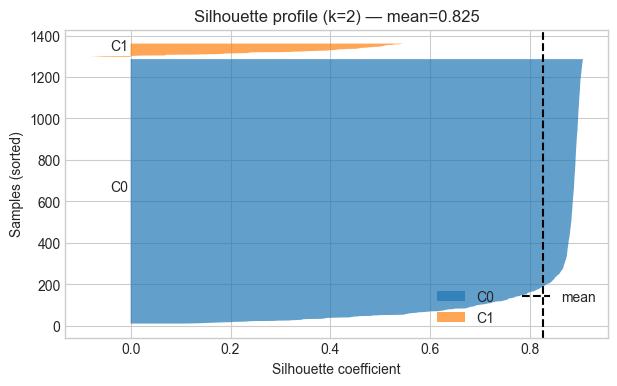

In [83]:
if labels_bins is not None:
    ari = adjusted_rand_score(labels_bins, clusters)
    print(f"Adjusted Rand Index vs manual = {ari:.3f}")
    print("\nContingency table (manual x cluster):")
    display(pd.crosstab(labels_bins, clusters, rownames=['Manual'], colnames=['Cluster']))

# silhouette profile (per-sample) for the chosen k
sil_vals = silhouette_samples(X_scaled, clusters)
fig, ax = plt.subplots(figsize=(7,4))
y_lower = 10
for c in sorted(np.unique(clusters)):
    sv = np.sort(sil_vals[clusters==c])
    size_c = len(sv)
    y_upper = y_lower + size_c
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sv, alpha=0.7, label=f"C{c}")
    ax.text(-0.04, y_lower + 0.5*size_c, f"C{c}")
    y_lower = y_upper + 10
ax.axvline(np.mean(sil_vals), color="k", ls="--", label="mean")
ax.set_xlabel("Silhouette coefficient"); ax.set_ylabel("Samples (sorted)")
ax.set_title(f"Silhouette profile (k={best_k}) — mean={np.mean(sil_vals):.3f}")
ax.legend(ncol=2, loc="lower right"); plt.show()


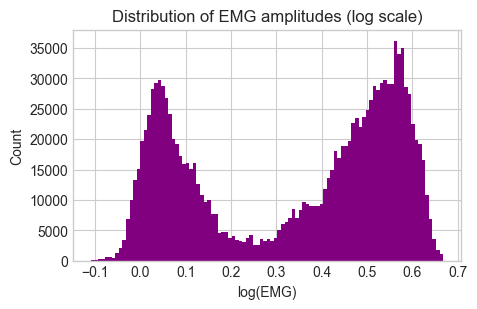

In [84]:
plt.figure(figsize=(5,3))
plt.hist(np.log1p(emg), bins=100, color="purple")
plt.title("Distribution of EMG amplitudes (log scale)")
plt.xlabel("log(EMG)")
plt.ylabel("Count")
plt.show()


###  Analysis

Even though the data wasn’t cleaned, it still holds biological structure (the algorithm could separate some sleep patterns). But since it only found 3 clusters instead of 4, this probably means noise, artefacts, or scale differences are still hiding finer distinctions. Once we apply proper preprocessing (filtering, artefact removal, EMG smoothing, normalization, etc.), the same K-means should give cleaner, more distinct clusters — proving our preprocessing improved the signal
